# **[Excercise 4]** Operational Energy System Optimization
In this notebook you are prompted to **understand the basics of data science** to examine *time series data* and aggregate it. Furthermore you are required to learn **basic financial mathematics** to evaluate the *profitability of financial assets*.

Furthermore we will cover the following Python basics:
- [x] Matplotlib
- [x] Pandas
- [x] Dictionaries
- [x] Classes

Company NewInnovativeGreenEnergySolutions operates a virtual power plant (VPP) that consists of multiple generation technologies that are listed with their technological parameters in Table 1. The company has access to the Day-Ahead (DA) electricity wholesale mar-ket, where it can sell generated electricity at market price. As part of its operational plan-ning, it should be decided how the VPP (and therefore the individual generation units) should be operated in order to maximize the profit margin. Support NewInnovative-GreenEnergySolutions in their decision by setting up and solving an optimization problem.

#### Specifications of the generation units of the VPP

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installed power of the PV system | $P_{inst,el}^{PV}$ | [$MW_{el}$] | 2
Variable costs of the PV system | $c_{gen}^{PV}$ | [$€/MWh$] | 0
Installed thermal power of the CHP system | $P_{inst,th}^{CHP}$ | [$MW_{th}$] | 2
Power-to-Heat ratio of the CHP system | $\sigma^{CHP}$ | [$MW_{el}/MW_{th}$] | 0.5
Variable cost of the CHP system | $c_{gen}^{CHP}$ | [$€$/$MWh_{el}$] | 20
Day-ahead wholesale market price | $p^{DA}$ | [$€$/$MWh$] | 15

</center>

In [279]:
params = {
    "PV Plant" : {
        "c_var" : 0,
        "p_max_inst" : 1.5
    },
    "CHP Plant" : {
        "c_var" : 20,
        "p_max_inst" : None,
        "th_max_inst" : 2,
        "power_to_heat" : 0.5
    },
    "c_rev" : 15
}

In [280]:
params["CHP Plant"]["p_max_inst"] = params["CHP Plant"]["power_to_heat"] * params["CHP Plant"]["th_max_inst"]
params

{'PV Plant': {'c_var': 0, 'p_max_inst': 1.5},
 'CHP Plant': {'c_var': 20,
  'p_max_inst': 1.0,
  'th_max_inst': 2,
  'power_to_heat': 0.5},
 'c_rev': 15}

## Task 4.0
Set up the optimization problem using Gurobi via the python module `gurobipy`.'

In [281]:
import gurobipy as gp

# Create the Gurobi model
model = gp.Model("virtual_power_plant")

Having initiated the optimization model, we will now build the model step by step by adding the variables, objective and constraints.
First, we will define the decision variables.
There are several types of variables based on the range of values they can take.
A **continuous** variable can take any real value within lower and upper bounds, whereas a **binary** variable can be either 0 or 1.

Our key decision variable is a continuous variable.
Let $z_{i,h}$ be the amount of power to be generated from power plant $i$ during hour $h$; this has to be *at least* $0$.

We can add this variable to the model using gurobipy's **addVars** function.

In [282]:
P = set(["PV Plant", "CHP Plant"])
H = set(range(1)) # Notice that Python is 0-based

y = model.addVars(P, H, name="y", lb=0)

In [283]:
o = {i: params[i]["c_var"] for i in P}
c = {i: params[i]["p_max_inst"] for i in P}

### Objective: Minimize the total costs 

Having defined the variables, we now tell the model what to optimize for.
We want to minimize the overall costs composed of five components - fuel, health, operating, startup and shutdown costs.
We can mathematically express the total cost using the decision variables as the following,

\begin{align*} 
\sum_{\textrm{plant}\ i} \sum_{\textrm{hour}\ h} (f_i z_{i,h} + a_{i,h} z_{i,h} + o_i u_{i,h} + s_i v_{i,h} + t_i w_{i,h})
\end{align*}

We now add this objective function to the model using the **setObjective** function.
The key input is the summation of all the terms.
Below is one way to add the five components one by one.

In [284]:
objective = gp.quicksum((params["c_rev"]-o[i])*y[i,h] for i in P for h in H) # fuel cost
model.setObjective(objective, sense=gp.GRB.MAXIMIZE)

### Constraint:  Maximum and minimum generation levels

We make sure that the power generated from each plant does not exceed the plant's maximum capacity (denoted by $c_i$). This constraint can be expressed by the inequality $z_{i,h} \leq c_i$ for each plant and hour.
We also want to make sure that when the plant is "off", i.e. when $u_{i,h}=0$, we do not generate any power, i.e. $z_{i,h}=0$.
We can capture this by the following inequality for each plant $i$ and hour $h$,

\begin{align*} 
z_{i,h} \leq c_i u_{i,h}
\end{align*}

Furthermore, recall that each plant needs to generate a certain minimum % amount of power (denoted by $m_i$).
Nuclear power plants must produce at least 80% of their capacity and the rest of the plants must produce at least 1% of their capacity.
This can be expressed by the following inequality for each power plant $i$ and hour $h$,

\begin{align*} 
z_{i,h}  \geq m_i c_i u_{i,h}
\end{align*}

Note that this constraint also ensures that when there is no power generated, i.e., $z_{i,h} = 0$, then the plant is said to be turned "off", i.e., $u_{i,h} =0$.

We now add these constraints to the model.

In [285]:
model.addConstrs((y[i,h] <= c[i]) for i in P for h in H)  

{('PV Plant', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('CHP Plant', 0): <gurobi.Constr *Awaiting Model Update*>}

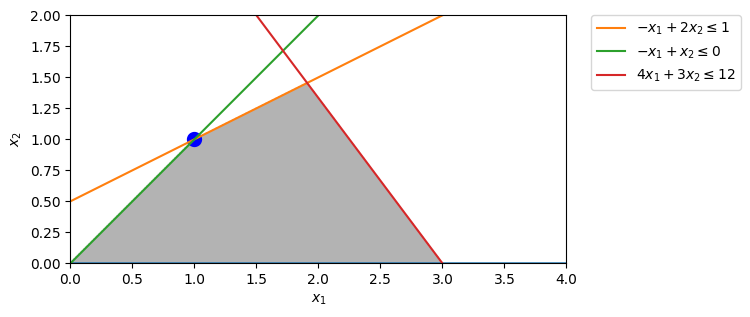

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feasible_space(x_star, y_star): 
    """
    x_star: optimum x
    y_star: optimum y
    
    """

    # plot the feasible region
    d = np.linspace(0,4,300)
    x,y = np.meshgrid(d,d)
    plt.imshow( ((y>=0) & (-x+2*y<=1) & (-x+y<=0) & (4*x+3*y<=12)).astype(int) , 
                    extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);


    # plot the lines defining the constraints
    x = np.linspace(0, 4, 2000)
    y1 = (x*0)
    y2 = 1/2 + x/2
    y3 = x
    y4 = 4-4/3*x

    # Make plot
    plt.plot(x, 0*np.ones_like(y1))
    plt.plot(x, y2, label=r'$-x_1+2x_2 \leq 1$')
    plt.plot(x, y3, label=r'$-x_1+x_2 \leq 0$')
    plt.plot(x, y4, label=r'$4x_1+3x_2 \leq 12$')
    plt.xlim(0,4)
    plt.ylim(0,2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.scatter(x_star, y_star, lw=5, c='b')
    
plot_feasible_space(1.0, 1.0)
    

In [287]:
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2 rows, 2 columns and 2 nonzeros
Model fingerprint: 0xd31ef5cf
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 2 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.250000000e+01


## Task 4.3
Assume the CHP additionally needs to provide $1 MW_{th}$ heat for a nearby district heating network that is remunerated with $10€/𝑀𝑊ℎ_{𝑡ℎ}$. Determine the new optimal solution as well as the new objective value.

In [288]:
model.addConstrs((y["CHP Plant",h] >= 1) for h in H)

objective = gp.quicksum((params["c_rev"]-o["PV Plant"]) * y["PV Plant",h] + (20 - 5) * y["CHP Plant",h] for h in H) # fuel cost
model.setObjective(objective, sense=gp.GRB.MAXIMIZE)

In [289]:
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3 rows, 2 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5000000e+31   1.000000e+30   1.500000e+01      0s
       1    3.7500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.750000000e+01


___
The company decided to additionally invest into a $5 MW$ wind turbine with the technological parameters listed in Table 3 and a forecasted feed-in of $P_{gen}^{Wind}$.

#### Specifications of the generation units of the VPP

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installed power of the wind turbine | $P_{inst,el}^{Wind}$ | [$MW_{el}$] | 5
Variable costs of the PV system | $c_{gen}^{Wind}$ | [$€/MWh$] | 2

</center>

## Task 4.4
Can the extended optimization problem be solved graphically? How should the wind turbine be operated?

In [290]:
params.update({
    "Wind turbine" : {
        "c_var" : 2,
        "p_max_inst" : 5
    }   
}
)

In [291]:
P = set(["PV Plant", "CHP Plant", "Wind turbine"])
ND = set(["PV Plant", "Wind turbine"])
H = set(range(1)) # Notice that Python is 0-based

y = model.addVars(P, H, name="y", lb=0)

In [292]:
o = {i: params[i]["c_var"] for i in P}
c = {i: params[i]["p_max_inst"] for i in P}

In [293]:
model.addConstrs((y[i,h] <= c[i]) for i in P for h in H)  

{('PV Plant', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('Wind turbine', 0): <gurobi.Constr *Awaiting Model Update*>,
 ('CHP Plant', 0): <gurobi.Constr *Awaiting Model Update*>}

In [294]:
model.addConstrs((y["CHP Plant",h] >= 1) for h in H)

objective = gp.quicksum((params["c_rev"]-o[n]) * y[n,h] + (20 - 5) * y["CHP Plant",h] for h in H for n in ND) # fuel cost
model.setObjective(objective, sense=gp.GRB.MAXIMIZE)

In [295]:
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7 rows, 5 columns and 7 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8000000e+31   3.000000e+30   5.800000e+01      0s
       3    1.1750000e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.175000000e+02


The operational decision is also extended to a consideration of multiple time steps (each time step is the equivalent of 6 hours) with a variable Day-Ahead wholesale market price $p_{t}^{DA}$ according to Figure 2 as well as variable generation from the RES plants in Figure 3 .

In [296]:
import pandas as pd

day_ahead_prices = pd.read_csv("../excercise_4/data/Day-ahead Prices_202303290000-202303300000.csv", index_col=[0])
day_ahead_prices.index = pd.to_datetime(day_ahead_prices.index.str.split("-").str[0])
prices = day_ahead_prices["Day-ahead Price [EUR/MWh]"]

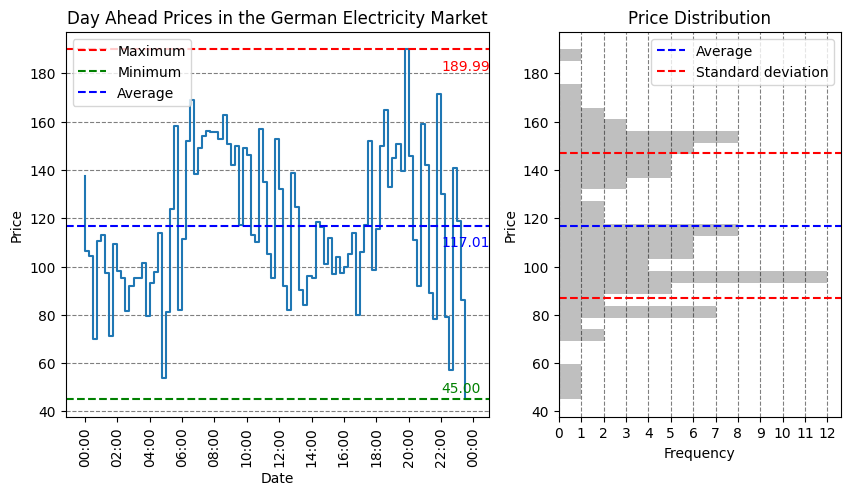

In [297]:
from utils import plot_electricity_prices

plot_electricity_prices(prices)

## Task 4.11
Repeat the same calculation, but this time resample the Pandas Series from 15min to 1h by using the average of the consecutive time steps.

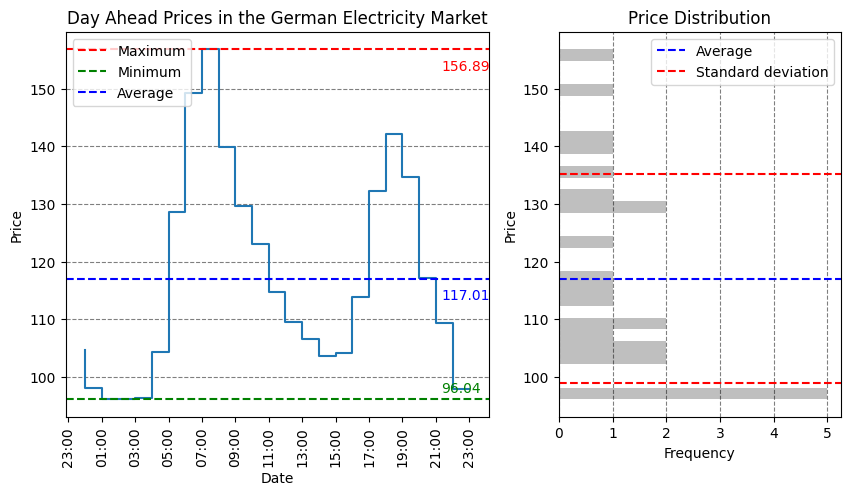

In [298]:
prices = prices.resample("1H").mean()
plot_electricity_prices(prices)

In [299]:
import json

# Load the JSON data
with open('../excercise_3/data/Timeseries_50.763_6.081_SA2_1kWp_crystSi_14_41deg_-2deg_2020_2020.json', 'r') as f:
    data = json.load(f)

# Extract the P values for each hour
hourly_data = data['outputs']['hourly']
P_values = np.array([hour['P'] for hour in hourly_data])

#Unfortunately, 2020 was a leap year, so we need to remove the additional day, so find the index of February 29th in the array
feb_29_index = 24 * (31 + 28) # Index of the last hour of Feb 28th

# Remove the data associated with February 29th from the array
P_values = np.delete(P_values, range(feb_29_index, feb_29_index + 24))

# Convert the hourly power output data into a Pandas series
pv_series = pd.Series(P_values, index=pd.date_range(start="01-01-2023 00:00", end="31-12-2023 23:00", freq='H'))
pv_feed_in = pv_series.loc[prices.index]

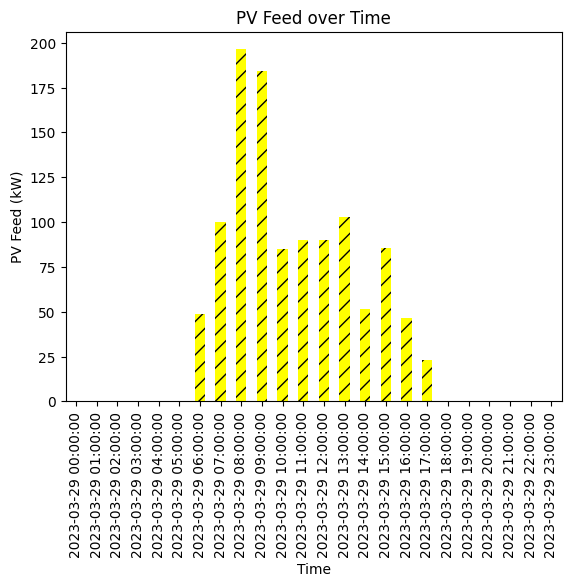

In [300]:
import matplotlib.pyplot as plt

# Assuming your pandas series is named 'prices'
fig, ax = plt.subplots()

# Plot the PV feed as a bar chart with blue stripes
ax = pv_feed_in.plot.bar(color='yellow', hatch='//')

# Add labels and title to the plot
ax.set_xlabel('Time')
ax.set_ylabel('PV Feed (kW)')
ax.set_title('PV Feed over Time')

# Show the plot
plt.show()

In [301]:
wind_feed_in = pd.read_csv("../excercise_4/data/wind_power_output.csv", index_col=[0], parse_dates=True)
wind_feed_in = wind_feed_in.loc[prices.index]
wind_feed_in

feedin_power_plant
MTU (CET/CEST)                         
2023-03-29 00:00:00       506923.439100
2023-03-29 01:00:00       496554.251485
2023-03-29 02:00:00       794671.573893
2023-03-29 03:00:00       432913.394548
2023-03-29 04:00:00       466651.610791
2023-03-29 05:00:00       406304.010090
2023-03-29 06:00:00       362021.365778
2023-03-29 07:00:00       417917.683577
2023-03-29 08:00:00       439891.653567
2023-03-29 09:00:00       450077.129160
2023-03-29 10:00:00       842181.358978
2023-03-29 11:00:00       863455.476089
2023-03-29 12:00:00       969832.432196
2023-03-29 13:00:00       926856.081822
2023-03-29 14:00:00       751452.714833
2023-03-29 15:00:00       537686.405806
2023-03-29 16:00:00       441882.929616
2023-03-29 17:00:00       708798.197852
2023-03-29 18:00:00       493725.257938
2023-03-29 19:00:00       598514.273626
2023-03-29 20:00:00       459059.254432
2023-03-29 21:00:00       638744.085666
2023-03-29 22:00:00       379156.812205
2023-03-29 23:00:00       723783.255113

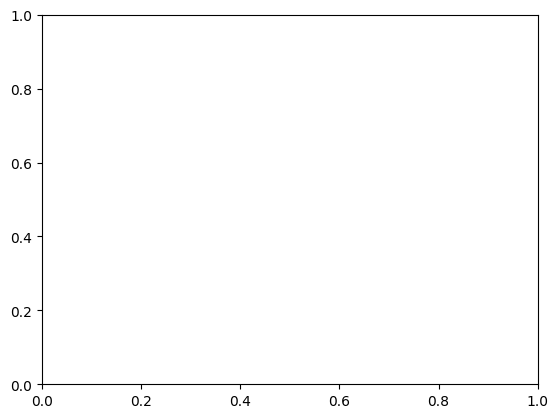

In [304]:
import matplotlib.pyplot as plt

# Assuming your pandas series is named 'prices'
fig, ax = plt.subplots()

# Plot the PV feed as a bar chart with blue stripes
ax = wind_feed_in.plot.bar(color='blue', hatch='//')

# Add labels and title to the plot
ax.set_xlabel('Time')
ax.set_ylabel('Wind Feed (kW)')
ax.set_title('Wind Feed over Time')

# Show the plot
plt.show()